## Imports

In [2]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from imutils import face_utils
import os
import time
from IPython.display import display, Image
# Configuration de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


## Paramètres d'enregistrement


In [3]:
frame_rate = 30  # Images par seconde
duration = 2     # Durée d'enregistrement en secondes
width = 640      # Largeur de la vidéo
height = 480     # Hauteur de la vidéo

# Chemin pour sauvegarder les fichiers vidéo et les images des lèvres
data_dir = "../data/video_recordings"
lip_dir = "../data/lip_frames"
os.makedirs(data_dir, exist_ok=True)
os.makedirs(lip_dir, exist_ok=True)

print(f"Paramètres : {frame_rate} FPS, {duration} secondes, résolution {width}x{height}")


Paramètres : 30 FPS, 2 secondes, résolution 640x480


## Initialisation du détecteur de visage et du prédicteur de points de repère


In [4]:
detector = dlib.get_frontal_face_detector()
# Le fichier shape_predictor_68_face_landmarks.dat doit être téléchargé séparément
predictor_path = "../models/shape_predictor_68_face_landmarks.dat"
if os.path.exists(predictor_path):
    predictor = dlib.shape_predictor(predictor_path)
    print("Détecteur de points de repère chargé !")
else:
    print(f"ATTENTION: Le fichier {predictor_path} n'a pas été trouvé.")
    print("Téléchargez-le depuis http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
    print("Puis décompressez-le et placez-le dans le dossier 'models'")


Détecteur de points de repère chargé !


## Définitions 

In [5]:
def record_video(duration=duration, frame_rate=frame_rate, width=width, height=height):
    """
    Enregistre une vidéo avec la webcam et retourne la liste des images.
    
    Args:
        duration: Durée d'enregistrement en secondes
        frame_rate: Images par seconde
        width: Largeur de la vidéo
        height: Hauteur de la vidéo
    
    Returns:
        list: Liste des images enregistrées
    """
    print(f"Enregistrement de {duration} secondes...")
    
    # Initialisation de la webcam
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    
    # Countdown
    for i in range(3, 0, -1):
        print(f"{i}...")
        time.sleep(1)
        
    print("Parlez maintenant !")
    
    frames = []
    start_time = time.time()
    
    while time.time() - start_time < duration:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convertir BGR en RGB pour l'affichage avec matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        
        # Afficher l'image en temps réel (optionnel)
        cv2.imshow('Recording', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Libérer la webcam et fermer les fenêtres
    cap.release()
    cv2.destroyAllWindows()
    
    print("Enregistrement terminé !")
    return frames

In [6]:
def extract_lip_region(frame, predictor=predictor, detector=detector):
    """
    Extrait la région des lèvres d'une image.
    
    Args:
        frame: Image à analyser
        predictor: Prédicteur de points de repère du visage
        detector: Détecteur de visage
    
    Returns:
        tuple: (region des lèvres, points des lèvres, visage détecté)
    """
    # Convertir en niveaux de gris pour la détection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Détecter les visages
    faces = detector(gray, 0)
    
    if len(faces) == 0:
        return None, None, None
    
    # Prendre le premier visage détecté
    face = faces[0]
    
    # Prédire les points de repère
    shape = predictor(gray, face)
    shape = face_utils.shape_to_np(shape)
    
    # Les points des lèvres sont les points 48-68 dans le modèle à 68 points
    lips_points = shape[48:68]
    
    # Calculer le rectangle englobant pour les lèvres
    x, y = lips_points.min(axis=0)
    w, h = lips_points.max(axis=0) - lips_points.min(axis=0)
    
    # Ajouter une marge
    margin = 10
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(frame.shape[1] - x, w + 2 * margin)
    h = min(frame.shape[0] - y, h + 2 * margin)
    
    # Extraire la région des lèvres
    lip_region = frame[y:y+h, x:x+w]
    
    return lip_region, lips_points, face

In [15]:
def process_video(frames):
    """
    Traite les images de la vidéo pour extraire et afficher les lèvres.
    
    Args:
        frames: Liste des images à traiter
    
    Returns:
        tuple: (liste des régions des lèvres, liste des points des lèvres)
    """
    lip_regions = []
    all_lip_points = []
    
    # Traiter toutes les images
    for frame in frames:
        lip_region, lip_points, _ = extract_lip_region(frame)
        if lip_region is not None and lip_points is not None:
            lip_regions.append(lip_region)
            all_lip_points.append(lip_points)
    
    # Sélectionner quelques images à afficher
    num_display = min(6, len(lip_regions))
    if num_display > 0:
        display_indices = np.linspace(0, len(lip_regions)-1, num_display, dtype=int)
        
        plt.figure(figsize=(16, 12))
        
        for i, idx in enumerate(display_indices):
            frame_idx = min(idx, len(frames)-1)
            frame = frames[frame_idx]
            lip_region = lip_regions[idx]
            lip_points = all_lip_points[idx]
            
            # Afficher l'image originale
            plt.subplot(3, num_display, i+1)
            plt.imshow(frame)
            plt.title(f'Image {frame_idx+1}')
            plt.axis('off')
            
            # Afficher l'image avec points de lèvres
            plt.subplot(3, num_display, i+1+num_display)
            plt.imshow(frame)
            plt.plot(lip_points[:, 0], lip_points[:, 1], 'ro', markersize=2)
            plt.title(f'Points des lèvres')
            plt.axis('off')
            
            # Afficher la région des lèvres
            plt.subplot(3, num_display, i+1+2*num_display)
            plt.imshow(lip_region)
            plt.title(f'Région des lèvres')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Afficher les statistiques
    if lip_regions:
        print(f"Nombre d'images avec lèvres détectées : {len(lip_regions)}/{len(frames)}")
        print(f"Taille moyenne de la région des lèvres : {np.mean([r.shape[0] for r in lip_regions]):.1f} x {np.mean([r.shape[1] for r in lip_regions]):.1f} pixels")
    else:
        print("Aucune lèvre détectée dans les images!")
    
    return lip_regions, all_lip_points

In [16]:
def save_video(frames, filename, fps=frame_rate):
    """
    Sauvegarde les images en tant que vidéo.
    
    Args:
        frames: Liste des images à sauvegarder
        filename: Nom du fichier (sans extension)
        fps: Images par seconde
    """
    if not frames:
        print("Aucune image à sauvegarder !")
        return None
    
    # Chemin complet
    full_path = os.path.join(data_dir, f"{filename}.mp4")
    
    # Taille de la première image
    h, w = frames[0].shape[:2]
    
    # Créer l'objet VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(full_path, fourcc, fps, (w, h))
    
    # Écrire chaque image dans le fichier vidéo
    for frame in frames:
        # Convertir RGB en BGR pour OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    
    # Libérer les ressources
    out.release()
    
    print(f"Vidéo sauvegardée dans {full_path}")
    return full_path

In [17]:
def save_lip_frames(lip_regions, filename_prefix):
    """
    Sauvegarde les régions des lèvres en tant qu'images.
    
    Args:
        lip_regions: Liste des régions des lèvres à sauvegarder
        filename_prefix: Préfixe pour les noms de fichiers
    """
    if not lip_regions:
        print("Aucune région des lèvres à sauvegarder !")
        return []
    
    saved_paths = []
    
    for i, lip_region in enumerate(lip_regions):
        # Chemin complet
        filename = f"{filename_prefix}_{i+1:03d}.png"
        full_path = os.path.join(lip_dir, filename)
        
        # Sauvegarder l'image
        cv2.imwrite(full_path, cv2.cvtColor(lip_region, cv2.COLOR_RGB2BGR))
        saved_paths.append(full_path)
    
    print(f"{len(saved_paths)} images de lèvres sauvegardées dans {lip_dir}")
    return saved_paths


In [18]:
def extract_features(lip_region, size=(64, 64)):
    """
    Extrait des caractéristiques simples à partir d'une région des lèvres.
    
    Args:
        lip_region: Image de la région des lèvres
        size: Taille cible pour le redimensionnement
        
    Returns:
        np.ndarray: Vecteur de caractéristiques
    """
    # Redimensionner l'image
    resized = cv2.resize(lip_region, size)
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    
    # Normaliser les valeurs entre 0 et 1
    normalized = gray / 255.0
    
    # Aplatir l'image pour obtenir un vecteur
    features = normalized.flatten()
    
    return features

In [19]:
def visualize_lip_features(lip_regions):
    """
    Visualise l'extraction de caractéristiques à partir des régions des lèvres.
    
    Args:
        lip_regions: Liste des régions des lèvres
    """
    if not lip_regions:
        print("Aucune région des lèvres à analyser !")
        return
    
    # Sélectionner quelques régions à afficher
    num_display = min(3, len(lip_regions))
    display_indices = np.linspace(0, len(lip_regions)-1, num_display, dtype=int)
    
    plt.figure(figsize=(16, 12))
    
    for i, idx in enumerate(display_indices):
        lip_region = lip_regions[idx]
        
        # Extraire les caractéristiques
        features = extract_features(lip_region)
        
        # Afficher la région des lèvres originale
        plt.subplot(3, num_display, i+1)
        plt.imshow(lip_region)
        plt.title(f'Région des lèvres {idx+1}')
        plt.axis('off')
        
        # Afficher l'image redimensionnée en niveaux de gris
        plt.subplot(3, num_display, i+1+num_display)
        resized = cv2.resize(lip_region, (64, 64))
        gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
        plt.imshow(gray, cmap='gray')
        plt.title(f'Niveaux de gris (64x64)')
        plt.axis('off')
        
        # Afficher les caractéristiques sous forme d'histogramme
        plt.subplot(3, num_display, i+1+2*num_display)
        plt.hist(features, bins=20, color='skyblue')
        plt.title(f'Distribution des caractéristiques ({len(features)} valeurs)')
        plt.xlabel('Valeur du pixel (normalisée)')
        plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Taille du vecteur de caractéristiques : {len(features)} valeurs par image")


Enregistrement de 2 secondes...
3...
2...
1...
Parlez maintenant !
Enregistrement terminé !


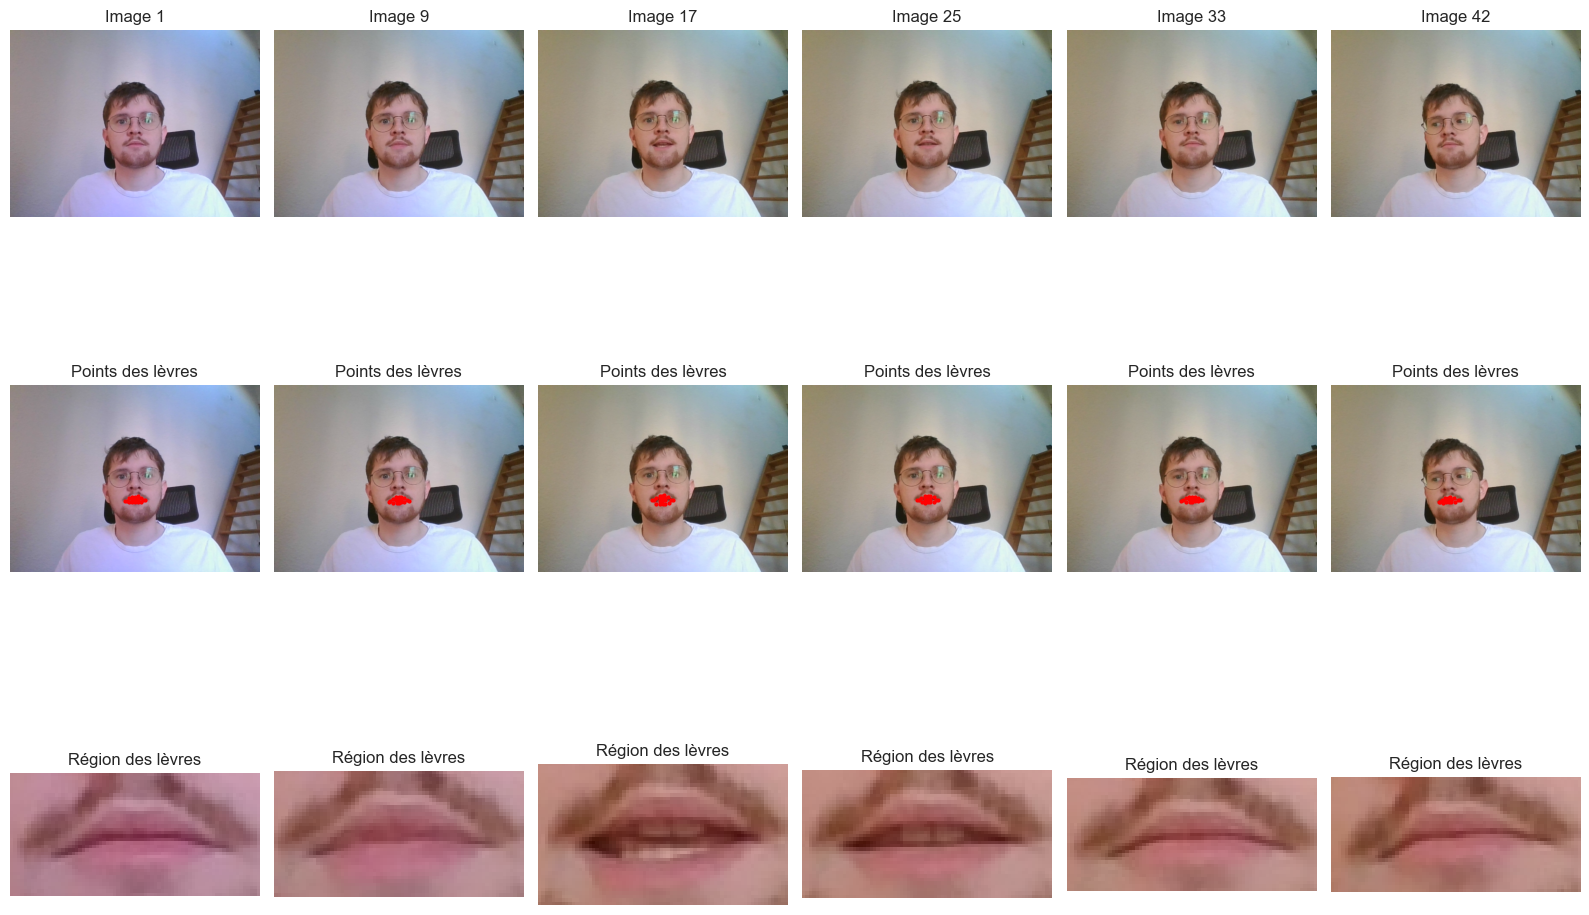

Nombre d'images avec lèvres détectées : 42/42
Taille moyenne de la région des lèvres : 36.5 x 72.7 pixels


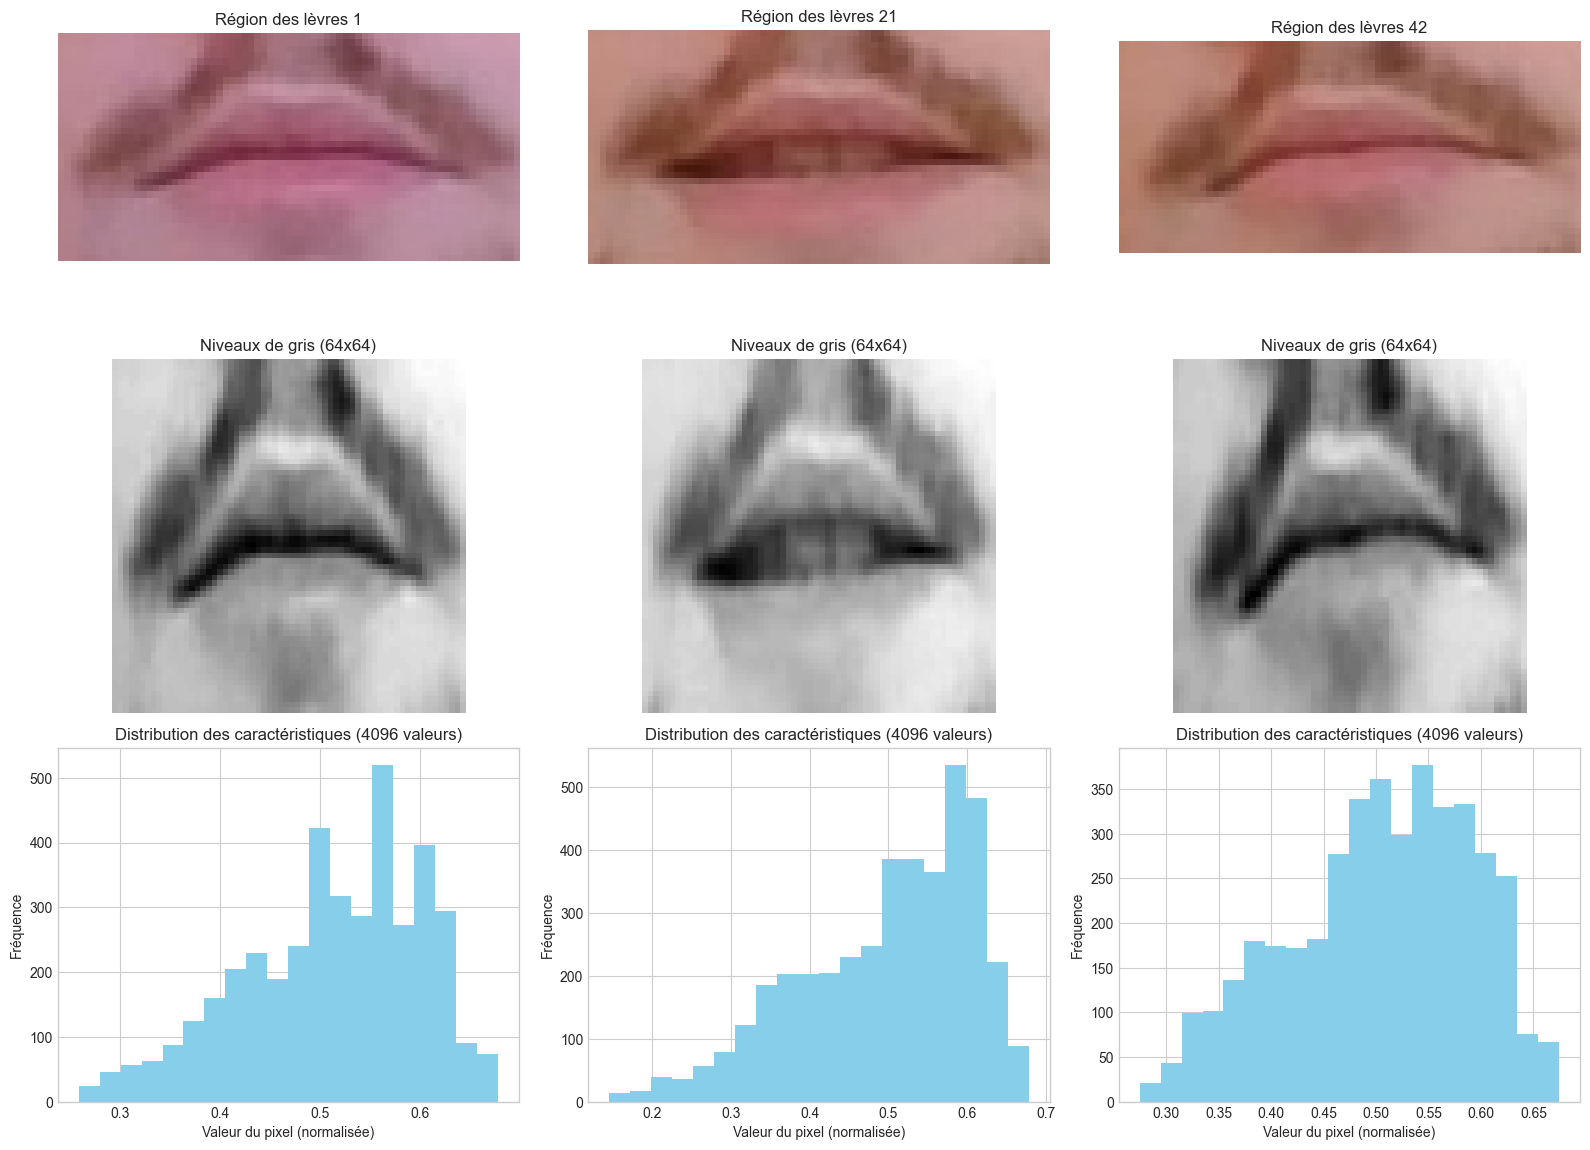

Taille du vecteur de caractéristiques : 4096 valeurs par image
Vidéo sauvegardée dans ../data/video_recordings\test_1.mp4
42 images de lèvres sauvegardées dans ../data/lip_frames


In [20]:
# Test complet
word = "test"  # Mot à prononcer

# Enregistrement
frames = record_video()

# Traitement et visualisation
lip_regions, lip_points = process_video(frames)

# Visualisation des caractéristiques
visualize_lip_features(lip_regions)

# Sauvegarde
if frames:
    video_path = save_video(frames, f"{word}_1")
    
if lip_regions:
    lip_paths = save_lip_frames(lip_regions, f"{word}_1")

In [21]:
def load_and_analyze_video(video_path):
    """
    Charge une vidéo, extrait les régions des lèvres et les analyse.
    
    Args:
        video_path: Chemin vers le fichier vidéo
    """
    # Vérifier si le fichier existe
    if not os.path.exists(video_path):
        print(f"Le fichier {video_path} n'existe pas !")
        return
    
    # Ouvrir la vidéo
    cap = cv2.VideoCapture(video_path)
    
    # Vérifier si la vidéo est ouverte correctement
    if not cap.isOpened():
        print(f"Impossible d'ouvrir la vidéo {video_path} !")
        return
    
    # Extraire les informations de la vidéo
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    print(f"Vidéo chargée : {video_path}")
    print(f"Résolution : {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
    print(f"FPS : {fps}")
    print(f"Nombre d'images : {frame_count}")
    print(f"Durée : {duration:.2f} secondes")
    
    # Lire toutes les images
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convertir BGR en RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    
    # Libérer les ressources
    cap.release()
    
    print(f"{len(frames)} images extraites")
    
    # Traiter et analyser les images
    lip_regions, lip_points = process_video(frames)
    
    # Visualiser les caractéristiques
    visualize_lip_features(lip_regions)
    
    return frames, lip_regions, lip_points


Vidéo chargée : ../data/video_recordings\test_1.mp4
Résolution : 640x480
FPS : 30.0
Nombre d'images : 42
Durée : 1.40 secondes
42 images extraites


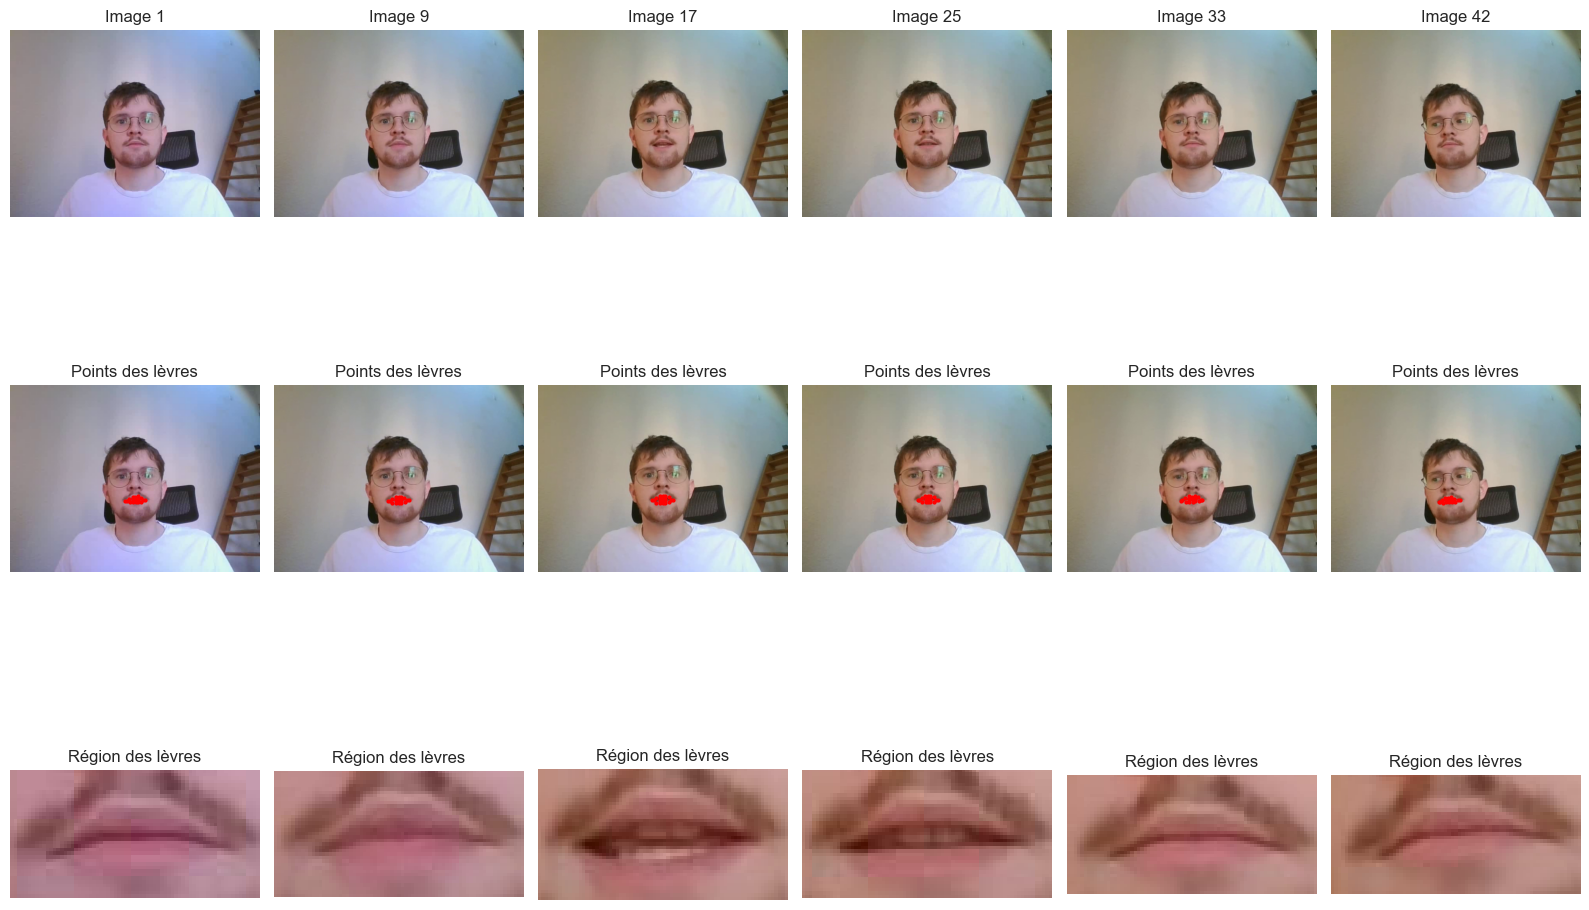

Nombre d'images avec lèvres détectées : 42/42
Taille moyenne de la région des lèvres : 36.5 x 73.0 pixels


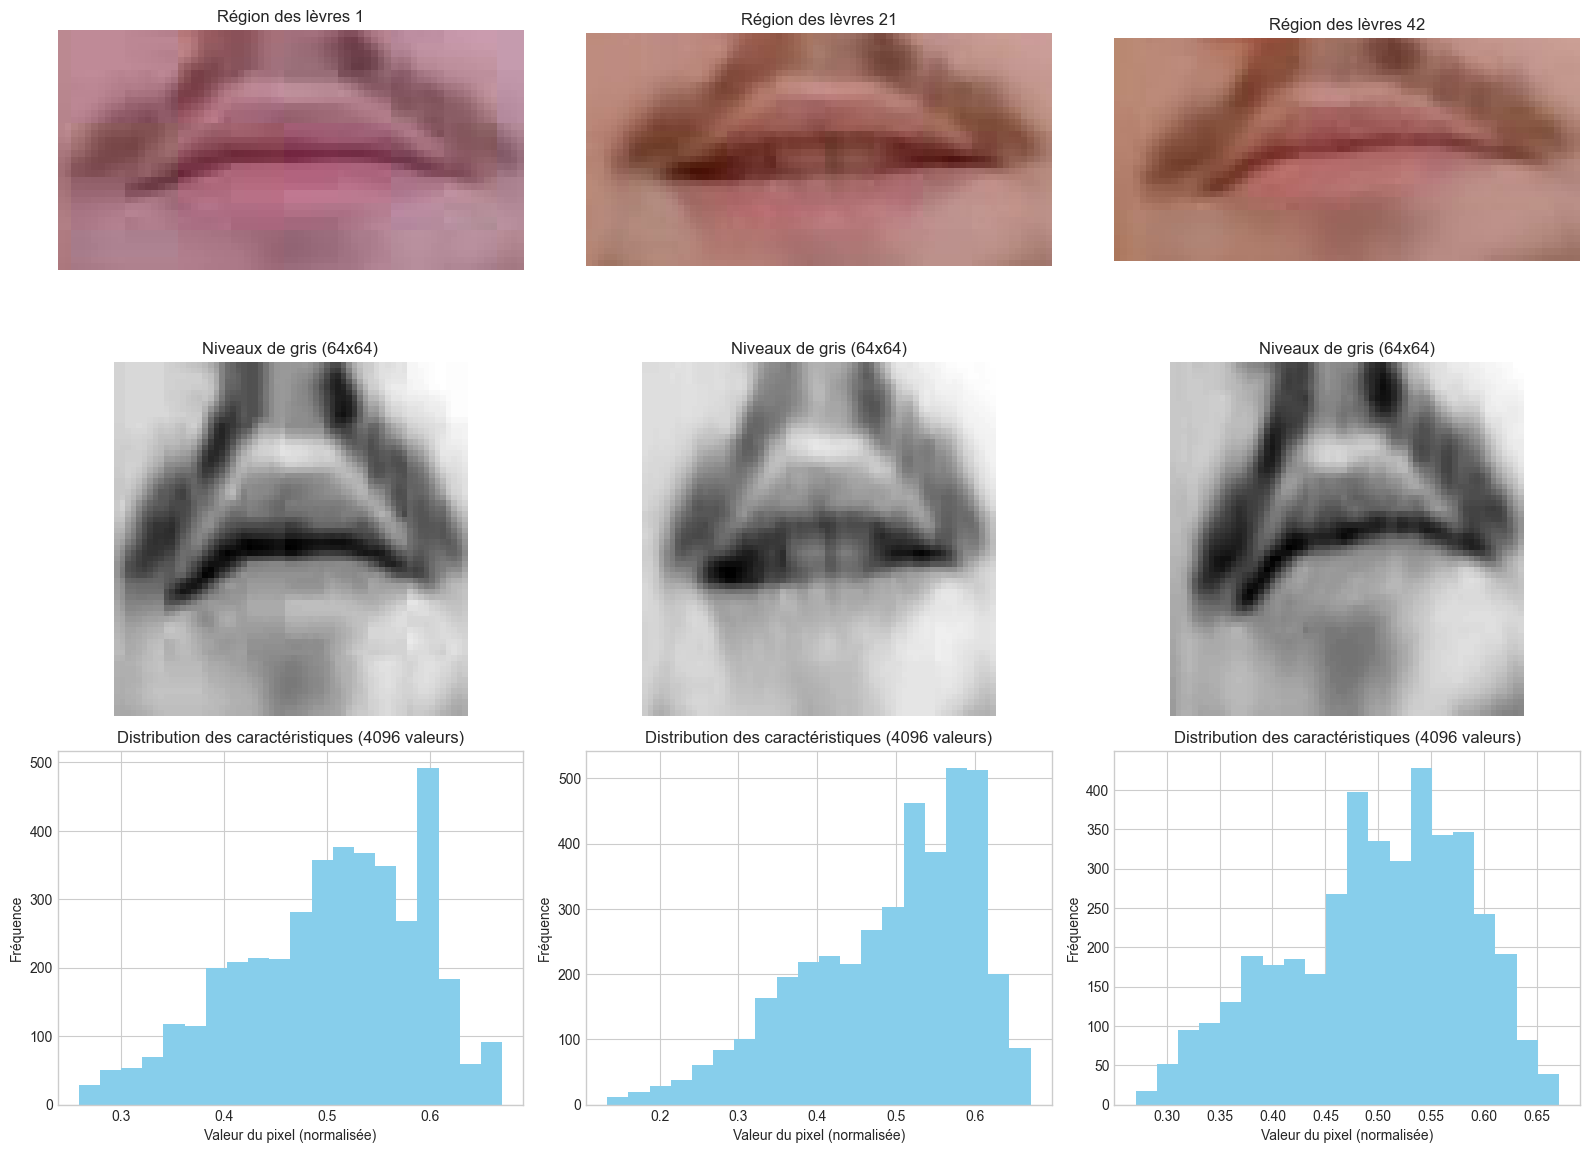

Taille du vecteur de caractéristiques : 4096 valeurs par image


In [22]:
if 'video_path' in locals():
    frames, lip_regions, lip_points = load_and_analyze_video(video_path)
else:
    print("Aucune vidéo n'a été enregistrée. Exécutez d'abord la cellule précédente.")